# Titanic
On s'intéresse cette fois-ci à un dataset très populaire dans la communauté ML. Les données sont tout simplement des informations sur les passagers et la variable à prédire... s'ils ont survécu ou non ! Pas mal non ?

https://www.kaggle.com/c/titanic/data

In [7]:
import pandas as pd

In [8]:
df = pd.read_csv("./titanic.csv")
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


On peut voir qu'il y a pas mal de variables catégorielles (c'est à dire non numériques et continues avec relation d'ordre). La variable à prédire est `Survived`. C'est une variable binaire (0 ou 1), c'est bien un problème de classification (binaire). On connait de nombreux algos capable de faire ça n'est-ce pas ?

Et puis il y a aussi ces données un peu étranges, `NaN` (Not a Number). Ces valeurs indiquent que la donnée correspondante est absente. Effectivement dans ce dataset il manque des données ! On peut voir quelles variables ont des "trous".

In [9]:
df.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

La variable `Age` a 177 valeurs manquantes ! Mais le pire c'est la variable `Cabin` qui en a 687. Est-ce qu'on peut quand même faire un apprentissage avec des données manquantes ? La réponse est plutôt non... Les modèles ont besoin des valeurs et ne peuvent pas faire sans s'ils utilisent la variable. Il faut adopter une stratégie.

* Prenons la variable `Age` qui contient des `NaN`. C'est une variable numérique. Une pratique courante est de remplacer les valeurs manquantes par la moyenne d'age calculée avec toutes les lignes où `Age` est renseigné. La médiane est aussi une solution. Bref, une méthode statistique de centre.
* On pourrait supprimer les lignes où les les valeurs de cette variable sont manquantes. Avec cette stratégie, on perd des lignes donc des données. Ce dataset étant déjà petit (891 lignes), les 177 lignes où `Age` est manquant serait une trop grosse perte. Ce n'est pas une bonne stratégie dans ce cas, mais si nosu avions seulement par exemple <5% de lignes avec `NaN`, nous aurions pu, par simplicité et pour éviter de biaisé la variable, supprimer ces lignes.

On choisit d'insérer l'âge moyen.

In [10]:
df_clean = df.copy()

# On remplace les NaN par la moyenne
df_clean["Age"] = df_clean["Age"].fillna(df_clean["Age"].mean())

# On fait de même pour la variable catégorielle Embarked, avec la valeur catégorielle la plus representée
most_voted = df_clean[["Embarked"]].groupby("Embarked").size().sort_values().index[-1]
df_clean["Embarked"] = df_clean["Embarked"].fillna(most_voted)

# On vérifie qu'il n'y a plus de NaN dans la variable Age
df_clean["Age"].isnull().sum()

0

Il faut maintenant traiter les variables catégorielles. Comme expliqué dans le sujet de régression, pour les variables avec des modalités non ordonnées on peut faire un One-hot encoding. La variable `Sex` prend les valeurs male et female. La variable `Embarked` prend les valeurs S, C et Q. Remplaçons les par 0 et 1.

In [11]:
df_clean["Sex"] = pd.get_dummies(df_clean["Sex"], drop_first=True)
df_clean = df_clean.join(pd.get_dummies(df_clean["Embarked"], drop_first=True).add_prefix("Embarked_"))
df_clean = df_clean.drop("Embarked", axis=1)
df_clean[["Sex", "Embarked_Q", "Embarked_S"]].head()

,Sex,Embarked_Q,Embarked_S
0,1,0,1
1,0,0,0
2,0,0,1
3,0,0,1
4,1,0,1


In [12]:
df_clean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,1


Voyons ce qu'il nous reste à voir. Il semble que les variables `Cabin`, `Name`, `Ticket` soient compliquées à convertir en valeur numérique calculable intéressante. Et puis il y a beaucoup de NaN dans la colonne Cabin. Voyons les différentes modalités prises pour ces 3 variables:

In [13]:
# Pour chaque variable, calcul le nombre de valeurs différentes
df_clean["Name"].nunique(), df_clean["Cabin"].nunique(), df_clean["Ticket"].nunique()

(891, 147, 681)

Pour ces varibales catégorielles, il y a bien trop de modalités différentes pour faire du One-hot encoding. On choisi alors par simplicité de supprimer ces variables. Enfin, la variable `PassengerId` est juste un numéro incrémental. Cette variable n'apporte pas vraiment d'information sur les passagers, on la supprime.

In [14]:
final_data = df_clean.drop(["Name", "Cabin", "Ticket", "PassengerId"], axis=1)
final_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,0,1
1,1,1,0,38.0,1,0,71.2833,0,0
2,1,3,0,26.0,0,0,7.9250,0,1
3,1,1,0,35.0,1,0,53.1000,0,1
4,0,3,1,35.0,0,0,8.0500,0,1


Rappel, la variable à prédire est `Survived` (0 ou 1), c'est un problème de classification.

# A vous de jouer
Visualiser les différentes variables, faire potentiellement une PCA, diviser les données en train/test puis appliquer les modèles vus en cours (et d'autres) pour construire le meilleur classifieur capable de prédire la variable `Survived`. Pourquoi pas faire un arbre et le visualiser pour comprendre les règles ? Utiliser Scikit-learn. Bonne chance ! 

PS: de manière générale, cherchez à visualiser et comprendre les données pour comprendre pourquoi ça marche bien ou pas, ne soyez pas étonné si les résultats ne sont pas bons au début

In [15]:
# Données numpy à utiliser
X = final_data.drop("Survived", axis=1).values
y = final_data["Survived"].values
X.shape, y.shape

((891, 8), (891,))

On peut étudier les corrélations entre les parametres du tabeau

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns

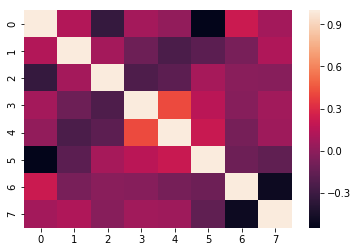

In [17]:
sns.heatmap(np.corrcoef(X.T))

In [18]:
def find_invers_coorelation(X):#trouve a liste des couple de parametres correles
    list_of_couple_of_arguments=[]
    for i in range(len(X[0])-1):
        for j in range(i+1,len(X[0]),1):
            if (np.sum(np.corrcoef(X[:,i],X[:,j]))==0):
                list_of_couple_of_arguments=np.append(list_of_couple_of_arguments,[i,j])
    return list_of_couple_of_arguments

print(find_invers_coorelation(X))
list_of_couple_of_param=find_invers_coorelation(X)

[]


Il semble qu'aucun parametre soit totalement correlé

In [21]:
np.corrcoef(X[:,6],X[:,7]) #pour

array([[ 1.        , -0.49942051],
       [-0.49942051,  1.        ]])